In [12]:
# first let's import our packages
import scipy.stats as scs
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data

#import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline
import random

import psytrack as psy
import clusteringFns as cf
import datetime

%load_ext autoreload
%autoreload 2

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

np.random.seed(2021)                # set seed for reproducibility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

seed = 1000
from tslearn.clustering import TimeSeriesKMeans

In [13]:
def simulateLearning(T = 10000, alpha = .05, beta = .1, theta = 0, bias = 0, max_num_cts = 0, init_Q = [0,0]):

    Q = init_Q.copy() # [0, 0] # Initial Q [L, H]

    stim_stored = np.zeros((T + 1, 2), dtype = float)
    firstRand = np.array(random.choices([0,1], weights = [0.5, 0.5], k = 1))[0]
    stim_stored[0] = [-1 * (1 - firstRand), firstRand]

    Q_stored = np.zeros((2, T), dtype = float)
    choiceProb = np.zeros((T), dtype = float)

    choice = np.zeros((T), dtype = float)
    reward = np.zeros((T), dtype = float)

    ct_count = 0

    for t in range(T):

        wT = stim_stored[t] * Q + bias
        pH = 1/(1 + np.exp(-(5 * np.exp(-theta)) * np.sum(wT)))

        choiceProb[t] = pH

        choice[t] = random.choices([0,1], weights = [1 - pH, pH], k = 1)[0]

        reward[t] = 0
        if int(stim_stored[t,1]) == int(choice[t]):
            reward[t] = 1

            newRand = random.choices([0,1], weights = [0.5, 0.5], k = 1)[0]
            ct_count = 0
        else:
            reward[t] = 0
            ct_count += 1

            if ct_count > max_num_cts:
                newRand = random.choices([0,1], weights = [0.5, 0.5], k = 1)[0]
            else:
                newRand = stim_stored[t][1]

        stim_stored[t+1] = [-1 * (1 - newRand), newRand]    

        # Update Values

        delta = reward[t] - Q[int(choice[t])]

        Q[int(choice[t])] = Q[int(choice[t])] + alpha * delta

        Q[1 - int(choice[t])] = Q[1 - int(choice[t])] - np.exp(-beta) * alpha * delta
        
        Q_stored[:,t] = Q

    stim_stored = stim_stored[0:T,:]

    return stim_stored, choice, reward, Q_stored, choiceProb

Starting Learing Simulation


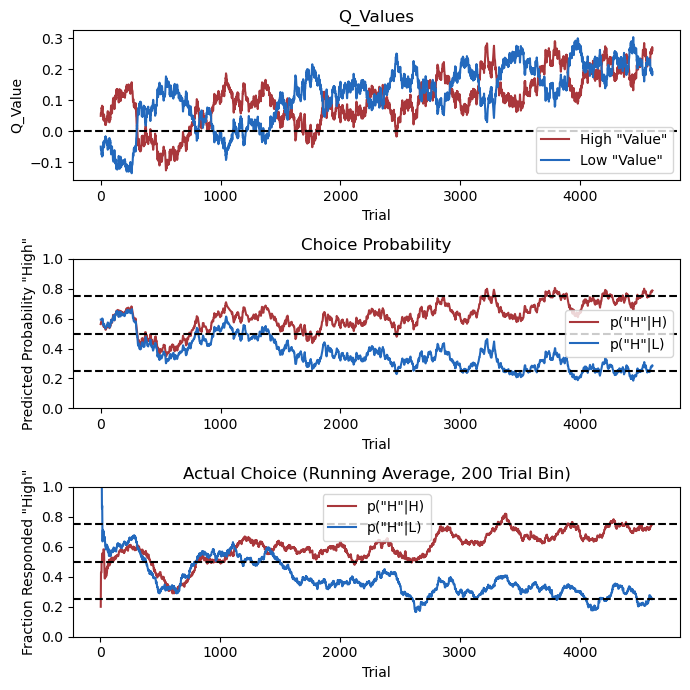

In [4]:
## Correction Trials

T = 20000 # Number of steps

alpha = .01 # "Rate", how much the prediction error updates the weights
beta = .02 # Generalization decay constant: how much does the "update" affect both stimulus associations vs. being stimulus-specific? High = more stimulus-specific
theta = 0 # When large, adds "randomness" to the decision function

bias = -0.0 # Initial starting bias (towards high), is added to the weight*stimulus before the logistic function.
iQ = [-0.05, 0.05]

max_num_cts = 3

print('Starting Learing Simulation')
stim_stored, choice, reward, Q_stored, choiceProb =  simulateLearning(T, alpha, beta, theta, bias, max_num_cts, init_Q = iQ)

trialN = np.array(range(1,T+1))

TL = trialN[stim_stored[:,1] == 0]
CL = choiceProb[stim_stored[:,1] == 0]
L =  1 - np.interp(trialN, TL, CL)

TH = trialN[stim_stored[:,1] == 1]
CH = choiceProb[stim_stored[:,1] == 1]
H = np.interp(trialN, TH, CH)

binL = choice.copy()
binL[stim_stored[:,1] == 1] = np.nan
binL = pd.Series(binL).rolling(200,5).apply(lambda x : np.nanmean(x))

binH = choice.copy()
binH[stim_stored[:,1] == 0] = np.nan
binH = pd.Series(binH).rolling(200,5).apply(lambda x : np.nanmean(x))

lowest = np.min([1 - binL, binH],0)
id = list(lowest > 0.75)
eOT = id.index(True)

lowcolor = "#2369BD"
highcolor = "#A9373B"

fig, axes = plt.subplots(3,1, figsize=(7,7))

axes[0].plot(Q_stored[1][0:eOT], label = 'High "Value"', color = highcolor)
axes[0].plot(Q_stored[0][0:eOT], label = 'Low "Value"', color = lowcolor)
axes[0].axhline(0, color = 'k', linestyle = '--')
axes[0].set_title('Q_Values')
axes[0].set_ylabel('Q_Value')
axes[0].legend()
axes[0].set_xlabel('Trial')

axes[1].plot(H[0:eOT], label = 'p("H"|H)', color = highcolor)
axes[1].plot(1 - L[0:eOT], label = 'p("H"|L)', color = lowcolor)
axes[1].axhline(0.25, color = 'k', linestyle = '--')
axes[1].axhline(0.5, color = 'k', linestyle = '--')
axes[1].axhline(0.75, color = 'k', linestyle = '--')
axes[1].set_ylim(0,1)
axes[1].set_ylabel('Predicted Probability "High"')
axes[1].set_xlabel('Trial')
axes[1].legend()
axes[1].set_title('Choice Probability')

axes[2].plot(binH[0:eOT], label = 'p("H"|H)', color = highcolor)
axes[2].plot(binL[0:eOT], label = 'p("H"|L)', color = lowcolor)
axes[2].axhline(0.25, color = 'k', linestyle = '--')
axes[2].axhline(0.5, color = 'k', linestyle = '--')
axes[2].axhline(0.75, color = 'k', linestyle = '--')
axes[2].set_ylim(0,1)
axes[2].set_ylabel('Fraction Responded "High"')
axes[2].legend()
axes[2].set_title('Actual Choice (Running Average, 200 Trial Bin)')
axes[2].set_xlabel('Trial')

plt.tight_layout()
plt.show()

In [136]:
## Correction Trials (Varying Initial Bias)

T = 15000 # Number of steps

alpha = .01 # "Rate", how much the prediction error updates the weights
beta = .02 # Generalization decay constant: how much does the "update" affect both stimulus associations vs. being stimulus-specific? High = more stimulus-specific
theta = 0 # When large, adds "randomness" to the decision function

bias = -0.00 # Initial starting bias (towards high), is added to the weight*stimulus before the logistic function.

iQ_bias = 0.2 # towards high

max_num_cts = 3

smoothF = 15
nPoints = 200
smooth2 = 5

nRuns = 20

rawTraceMat = np.zeros((nRuns, nPoints*2))

for runN in range(0,nRuns):
    
    iQ_bias = (runN/nRuns) - 0.5

    iQ = [-1*iQ_bias, iQ_bias]
    stim_stored, choice, reward, Q_stored, choiceProb =  simulateLearning(T, alpha, beta, theta, bias, max_num_cts, iQ)

    trialN = np.array(range(1,T+1))

    TL = trialN[stim_stored[:,1] == 0]
    CL = choiceProb[stim_stored[:,1] == 0]
    L =  1 - np.interp(trialN, TL, CL)

    TH = trialN[stim_stored[:,1] == 1]
    CH = choiceProb[stim_stored[:,1] == 1]
    H = np.interp(trialN, TH, CH)

    binL = choice.copy()
    binL[stim_stored[:,1] == 1] = np.nan
    
    binLt = pd.Series(binL.copy()).rolling(200,50).apply(lambda x : np.nanmean(x))

    binH = choice.copy()
    binH[stim_stored[:,1] == 0] = np.nan

    binHt = pd.Series(binH.copy()).rolling(200,50).apply(lambda x : np.nanmean(x))

    lowest = np.min([1 - binLt, binHt],0)
    id = list(lowest > 0.75)
    eOT = id.index(True)

    acc_low = binL[0:eOT]
    acc_high = binH[0:eOT]

    idx = np.array(range(0,len(acc_low)))
    smooth = int(np.round(len(acc_low)/smoothF,0))

    acc_low_t = pd.Series(acc_low).rolling(smooth,5).apply(lambda x : np.nanmean(x))
    acc_high_t = pd.Series(acc_high).rolling(smooth,5).apply(lambda x : np.nanmean(x))

    temp_mold = np.round(np.linspace(0,len(acc_low)-1,nPoints + 1))

    wModeRaws = []

    binnedMean,binnedIdx, *_ = scs.binned_statistic(idx, acc_low_t, statistic=np.nanmean, bins = temp_mold, range=(idx.min(),idx.max()))
    binnedMean = pd.Series(binnedMean).rolling(smooth2,1).apply(lambda x : np.nanmean(x))
    if np.isnan(binnedMean[0]):
        binnedMean[0] = binnedMean[1]    
    wModeRaws.extend(binnedMean)

    binnedMean,binnedIdx, *_ = scs.binned_statistic(idx, acc_high_t, statistic=np.nanmean, bins = temp_mold, range=(idx.min(),idx.max()))
    binnedMean = pd.Series(binnedMean).rolling(smooth2,1).apply(lambda x : np.nanmean(x))
    if np.isnan(binnedMean[0]):
        binnedMean[0] = binnedMean[1]
    wModeRaws.extend(binnedMean)

    rawTraceMat[runN,:] = wModeRaws

[0.58852479 0.66472465 0.72802124 0.78540963 0.82327255 0.85203414]


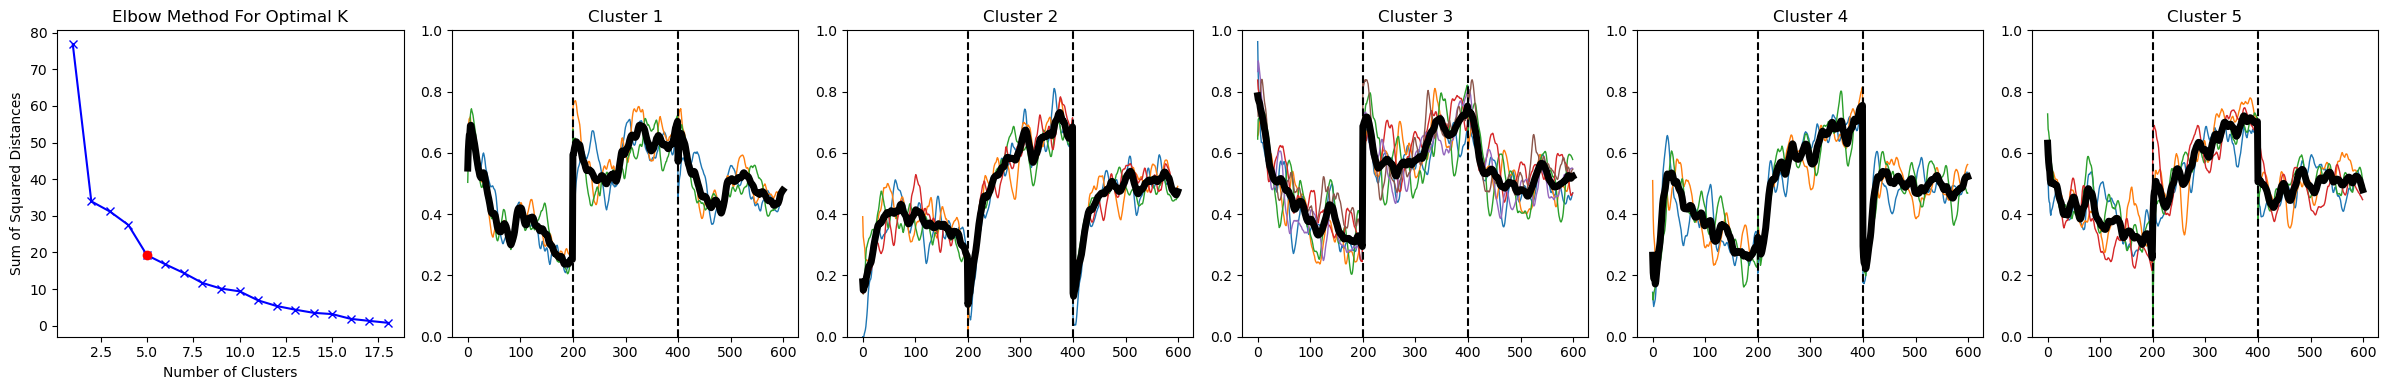

In [145]:
X = rawTraceMat
temp = (X[:,0:nPoints] + X[:,nPoints:(2*nPoints)])/2
X = np.hstack([X, temp])

x_pred_pca, x_pca, axs = cf.pca_kmeans(X, nPoints, n_components = 6, k = 5, plot = True)
for ai, axi in enumerate(axs):
    if ai > 0:
        axi.set_ylim(-0, 1)
plt.tight_layout()
plt.show()


In [135]:
np.isnan(binnedMean[0])

True

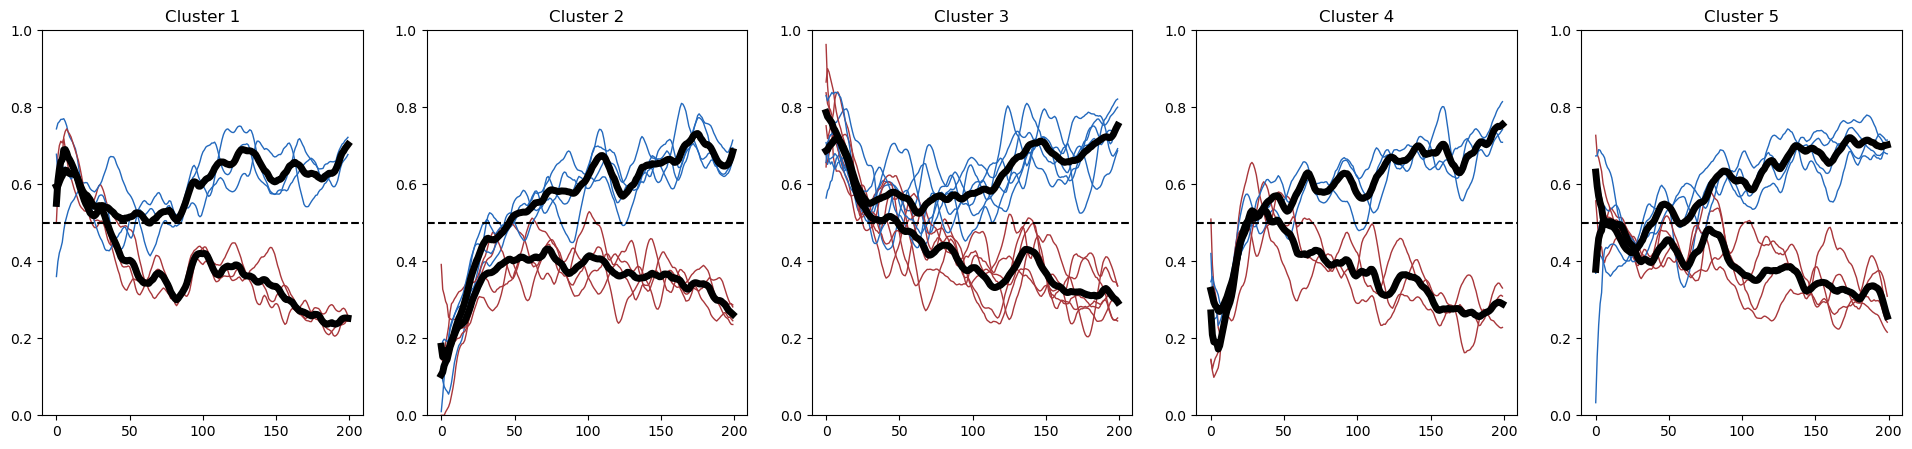

In [146]:
fig, axs = plt.subplots(1,len(np.unique(x_pred_pca)), figsize = (24,5))

colrs = ('green', 'red', 'blue', 'orange', 'magenta', 'yellow', 'purple')
means = []
for ia, ax in enumerate(axs):
    tempt = X[x_pred_pca == ia,:].T
    
    # idsT = np.array(ids[x_pred_pca == ia])
    # tempM = [mun for mi, mun in enumerate(lambdas) if mu_IDs[mi] in idsT]
    # tempM = round(np.mean(tempM),2)
    # means.append(tempM)
            
    for ii, temp in enumerate(tempt.T):

        ax.plot(np.array(range(0,nPoints)), temp[0:nPoints], linewidth = 1, color = highcolor)#colrs[ii])
        ax.plot(np.array(range(0,nPoints)), temp[nPoints:(2*nPoints)], linewidth = 1, color = lowcolor)#colrs[ii])

    ax.plot(np.array(range(0,nPoints)), tempt.T[:,0:nPoints].mean(0), linewidth = 5, color = 'black')
    ax.plot(np.array(range(0,nPoints)), tempt.T[:,nPoints:(2*nPoints)].mean(0), linewidth = 5, color = 'black')

    ax.set_ylim(0,1)
    #ax.axvline(500, color = 'k', linestyle = '--')
#    ax.axvline(1000, color = 'k', linestyle = '--')
    ax.axhline(0.5, color = 'k', linestyle = '--')
    ax.set_title('Cluster ' + str(ia+1))

In [99]:
## Correction Trials

T = 20000 # Number of steps

alpha = .01 # "Rate", how much the prediction error updates the weights
beta = .01 # Generalization decay constant: how much does the "update" affect both stimulus associations vs. being stimulus-specific? High = more stimulus-specific
theta = 0 # When large, adds "randomness" to the decision function

bias = -0.00 # Initial starting bias (towards high), is added to the weight*stimulus before the logistic function.

iQ_bias = 0.2 # towards high

max_num_cts = 3

smoothF = 15
nPoints = 200
smooth2 = 5

nRuns = 20

rawTraceMat = np.zeros((nRuns, nPoints*2))

for runN in range(0,nRuns):
    
    iQ_bias = 0 #(runN/nRuns) - 0.5

    iQ = [-1*iQ_bias, iQ_bias]
    stim_stored, choice, reward, Q_stored, choiceProb =  simulateLearning(T, alpha, beta, theta, bias, max_num_cts, iQ)

    trialN = np.array(range(1,T+1))

    TL = trialN[stim_stored[:,1] == 0]
    CL = choiceProb[stim_stored[:,1] == 0]
    L =  1 - np.interp(trialN, TL, CL)

    TH = trialN[stim_stored[:,1] == 1]
    CH = choiceProb[stim_stored[:,1] == 1]
    H = np.interp(trialN, TH, CH)

    binL = choice.copy()
    binL[stim_stored[:,1] == 1] = np.nan
    
    binLt = pd.Series(binL.copy()).rolling(200,50).apply(lambda x : np.nanmean(x))

    binH = choice.copy()
    binH[stim_stored[:,1] == 0] = np.nan

    binHt = pd.Series(binH.copy()).rolling(200,50).apply(lambda x : np.nanmean(x))

    lowest = np.min([1 - binLt, binHt],0)
    id = list(lowest > 0.75)
    eOT = id.index(True)

    acc_low = binL[0:eOT]
    acc_high = binH[0:eOT]

    idx = np.array(range(0,len(acc_low)))
    smooth = int(np.round(len(acc_low)/smoothF,0))

    acc_low_t = pd.Series(acc_low).rolling(smooth,5).apply(lambda x : np.nanmean(x))
    acc_high_t = pd.Series(acc_high).rolling(smooth,5).apply(lambda x : np.nanmean(x))

    temp_mold = np.round(np.linspace(0,len(acc_low)-1,nPoints + 1))

    wModeRaws = []

    binnedMean,binnedIdx, *_ = scs.binned_statistic(idx, acc_low_t, statistic=np.nanmean, bins = temp_mold, range=(idx.min(),idx.max()))
    binnedMean = pd.Series(binnedMean).rolling(smooth2,1).apply(lambda x : np.nanmean(x))
    wModeRaws.extend(binnedMean)

    binnedMean,binnedIdx, *_ = scs.binned_statistic(idx, acc_high_t, statistic=np.nanmean, bins = temp_mold, range=(idx.min(),idx.max()))
    binnedMean = pd.Series(binnedMean).rolling(smooth2,1).apply(lambda x : np.nanmean(x))
    wModeRaws.extend(binnedMean)

    rawTraceMat[runN,:] = wModeRaws

array([ 0.97049478, -0.42854424,  0.56540913, -0.18040254,  0.209237  ,
       -0.54293802, -0.02393341,  0.2424533 , -0.97257722, -0.91627435])

Starting Learing Simulation


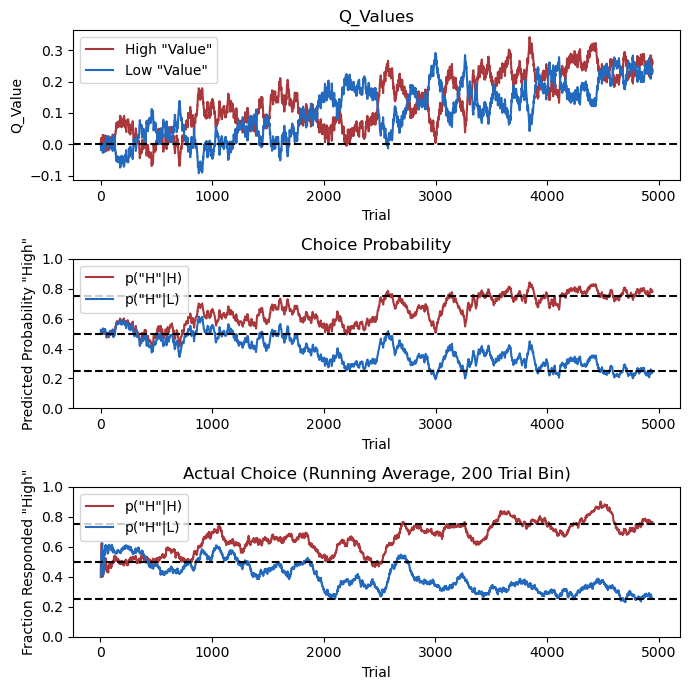

In [11]:
## Correction Trials

T = 20000 # Number of steps

alpha = .01 # "Rate", how much the prediction error updates the weights
beta = 0.02 # Generalization decay constant: how much does the "update" affect both stimulus associations vs. being stimulus-specific? High = more stimulus-specific
theta = 0 # When large, adds "randomness" to the decision function

bias = -0.0 # Initial starting bias (towards high), is added to the weight*stimulus before the logistic function.
iQ = [0,0]#[-0.05, 0.05]

max_num_cts = 3

print('Starting Learing Simulation')
stim_stored, choice, reward, Q_stored, choiceProb =  simulateLearning(T, alpha, beta, theta, bias, max_num_cts, init_Q = iQ)

trialN = np.array(range(1,T+1))

TL = trialN[stim_stored[:,1] == 0]
CL = choiceProb[stim_stored[:,1] == 0]
L =  1 - np.interp(trialN, TL, CL)

TH = trialN[stim_stored[:,1] == 1]
CH = choiceProb[stim_stored[:,1] == 1]
H = np.interp(trialN, TH, CH)

binL = choice.copy()
binL[stim_stored[:,1] == 1] = np.nan
binL = pd.Series(binL).rolling(200,5).apply(lambda x : np.nanmean(x))

binH = choice.copy()
binH[stim_stored[:,1] == 0] = np.nan
binH = pd.Series(binH).rolling(200,5).apply(lambda x : np.nanmean(x))

lowest = np.min([1 - binL, binH],0)
id = list(lowest > 0.75)
if True in id:
    eOT = id.index(True)
else: eOT = T

lowcolor = "#2369BD"
highcolor = "#A9373B"

fig, axes = plt.subplots(3,1, figsize=(7,7))

axes[0].plot(Q_stored[1][0:eOT], label = 'High "Value"', color = highcolor)
axes[0].plot(Q_stored[0][0:eOT], label = 'Low "Value"', color = lowcolor)
axes[0].axhline(0, color = 'k', linestyle = '--')
axes[0].set_title('Q_Values')
axes[0].set_ylabel('Q_Value')
axes[0].legend()
axes[0].set_xlabel('Trial')

axes[1].plot(H[0:eOT], label = 'p("H"|H)', color = highcolor)
axes[1].plot(1 - L[0:eOT], label = 'p("H"|L)', color = lowcolor)
axes[1].axhline(0.25, color = 'k', linestyle = '--')
axes[1].axhline(0.5, color = 'k', linestyle = '--')
axes[1].axhline(0.75, color = 'k', linestyle = '--')
axes[1].set_ylim(0,1)
axes[1].set_ylabel('Predicted Probability "High"')
axes[1].set_xlabel('Trial')
axes[1].legend()
axes[1].set_title('Choice Probability')

axes[2].plot(binH[0:eOT], label = 'p("H"|H)', color = highcolor)
axes[2].plot(binL[0:eOT], label = 'p("H"|L)', color = lowcolor)
axes[2].axhline(0.25, color = 'k', linestyle = '--')
axes[2].axhline(0.5, color = 'k', linestyle = '--')
axes[2].axhline(0.75, color = 'k', linestyle = '--')
axes[2].set_ylim(0,1)
axes[2].set_ylabel('Fraction Responded "High"')
axes[2].legend()
axes[2].set_title('Actual Choice (Running Average, 200 Trial Bin)')
axes[2].set_xlabel('Trial')

plt.tight_layout()
plt.show()

In [9]:
False in id

True